## Car trajectory prediction

## We choose a window of 60 time steps
## We want to learn 48 steps and predict 12 steps.
## Each step = 1 second

In [1]:
import sys
sys.path.append('../')

import pandas as pd
import numpy as np
import keras
from datetime import datetime, timedelta
from utils import windowing_array
from sklearn.model_selection import train_test_split
from utils import split_sequence_long

%load_ext autoreload
%autoreload 2

2024-05-28 15:07:45.854058: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-28 15:07:46.053900: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-28 15:07:46.053944: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-28 15:07:46.086996: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-28 15:07:46.157056: I tensorflow/core/platform/cpu_feature_guar

### Data Exploration

In [2]:
csv_input = pd.read_csv('dataset_trajectory.csv')
data = csv_input

In [3]:
# show head
print(data.shape)
data.head()

(4597200, 6)


,pos.x,pos.y,pos.z,heading,velocity,weather
0,-77.030670,-1.283448,0.294200,-1.568362,7.056001,2
1,-77.030670,-1.283448,0.061311,-1.568362,7.172558,2
2,-77.029778,-1.283539,-0.030319,-1.568443,1.053028,2
3,-77.028854,-1.283728,-0.023681,-1.568593,0.883579,2
4,-77.008575,-1.288779,0.003869,-1.572756,1.548891,2


In [4]:
# Remove rows with any NaN values
data = data.dropna()
print(len(data))

4597200


### Time

In [5]:
## Adding date time
# Start datetime
start_datetime = datetime(2009, 1, 1, 0, 0, 0)

# Generate datetime column with incrementing seconds
num_rows = len(data)
seconds_increment = timedelta(seconds=1)

date_times = [start_datetime + i * seconds_increment for i in range(num_rows)]

# Add datetime column to DataFrame
data['Date Time'] = date_times

In [6]:
date_time = pd.to_datetime(data.pop('Date Time'), format='%d.%m.%Y %H:%M:%S')
timestamp_s = date_time.map(pd.Timestamp.timestamp)
minute = 60
data['Minute sin'] = np.sin(timestamp_s * (2 * np.pi / minute))
data['Minute cos'] = np.cos(timestamp_s * (2 * np.pi / minute))

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4597200 entries, 0 to 4597199
Data columns (total 8 columns):
 #   Column      Dtype  
---  ------      -----  
 0   pos.x       float64
 1   pos.y       float64
 2   pos.z       float64
 3   heading     float64
 4   velocity    float64
 5   weather     int64  
 6   Minute sin  float64
 7   Minute cos  float64
dtypes: float64(7), int64(1)
memory usage: 280.6 MB


### Windowing
We choose a window of 60 time steps
We want to learn 48 steps and predict 12 steps.

In [8]:
window_size = 60
grouped_data = windowing_array(data, window_size)

In [9]:
print(len(grouped_data))
print(len(grouped_data[0]))
print(len(grouped_data[0][0]))

76620
60
8


### Slice and Split sequence 

In [10]:
x_train_init, x_test_init = train_test_split(grouped_data, shuffle=False, test_size=0.2)

In [11]:
x_train_init.shape, x_test_init.shape

((61296, 60, 8), (15324, 60, 8))

In [12]:
## slipt x_train_init to x_train, y_train, y_train_shifted_by_one

x_train, y_train, y_train_shifted_by_one = split_sequence_long(x_train_init)

In [13]:
x_train.shape, y_train.shape

((61296, 48, 8), (61296, 12, 8))

In [14]:
x_train.shape[0], x_train.shape[1], x_train.shape[2]

(61296, 48, 8)

In [15]:
## First Let's start with predict only one input
#y_train = y_train[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_train = y_train[:,:,:2]

In [16]:
y_train.shape

(61296, 12, 2)

In [17]:
## slipt x_test_init to y_test, y_test_shift_by_one, y_test
x_test, y_test, y_test_shifted_by_one = split_sequence_long(x_test_init)

In [18]:
x_test.shape, y_test.shape

((15324, 48, 8), (15324, 12, 8))

In [19]:
## First Let's start with predict only one input
#y_test = y_test[:,:,:1]

## Now let's try to predict two inputs (posx and posy)
y_test = y_test[:,:,:2]

In [20]:
y_test.shape

(15324, 12, 2)

### Model Configuration

In [21]:
# Define the input shape
input_shape = x_train.shape[1:]
input_shape

(48, 8)

In [22]:
# Define the output shape
outout_shape = y_train.shape[1:]
outout_shape

(12, 2)

In [23]:
# Define the output vector size
y_train_feature_nr = len(y_train[1])
output_seq_size = 2
output_features_vector=y_train_feature_nr * output_seq_size
output_features_vector

24

### Train and evaluate

In [26]:
from transformer import ITPF_Transformer


model = ITPF_Transformer()

In [27]:
model = model.build_model(
    input_shape=input_shape, 
    output_shape=outout_shape,
    output_features_vector=output_features_vector, 
    head_size=256,
    num_heads=4,
    ff_dim=4,
    num_transformer_blocks=4,
    mlp_units=[128],
    mlp_dropout=0.4,
    dropout=0.25
)

In [ ]:
epochs = 100
batch_size = 32

callbacks = [
    keras.callbacks.ModelCheckpoint(
        "best_model_long_2.keras", save_best_only=True, monitor="val_loss"
    ),
    keras.callbacks.ReduceLROnPlateau(
        monitor="val_loss", factor=0.5, patience=20, min_lr=0.0001
    ),
    keras.callbacks.EarlyStopping(monitor="val_loss", patience=50, verbose=1),
]
model.compile(
    optimizer="adam",
    loss=["mse"],
    metrics=['mae'],
)
history = model.fit(
    x_train,
    y_train,
    batch_size=batch_size,
    epochs=epochs,
    callbacks=callbacks,
    validation_split=0.2,
    verbose=1,
)

In [ ]:
#model.summary()

In [25]:
model = keras.models.load_model("best_model_long_2.keras")

test_loss, test_acc = model.evaluate(x_test, y_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

479/479 [==============================] - 9s 18ms/step - loss: 173.1331 - mae: 8.2289
Test accuracy 8.228937149047852
Test loss 173.13311767578125


## Explainer

In [26]:
predictions = model.predict(x_test)

479/479 [==============================] - 9s 18ms/step


In [27]:
predictions.shape

(15324, 12, 2)

In [28]:
from sklearn.metrics import mean_squared_error

y = x_test[0]
y_true = y_test[0]
y_pred = predictions[0]
print("Acc:", mean_squared_error(y_true, y_pred))

Acc: 57.33771013445221


Our model takes 3D inputs (np.array) and returns 3D output (np.array)

We need to create a black-box wrapper that when it takes 2D input, it will transform it to 3D for prediction.

In [29]:
from sklearn.metrics import mean_squared_error

class BlackBoxWrapper():
    def __init__(self, model):
        self.clf = model

    def _is_3d(self, data):
        y = False
        if data.ndim == 3:
            y = True
        return y

    def _is_2d(self, data):
        y = False
        if data.ndim == 2:
            y = True
        return y
    
    def _is_1d(self, data):
        y = False
        if data.ndim == 1:
            y = True
        return y

    def _transform_to_3d(self, data):
        y = data.reshape((1, data.shape[0], data.shape[1])) #(num_samples, sample_size, nu_features)
        return y

    def _transform_to_2d(self, data):
        y = data.reshape(data.shape[0]*data.shape[1], data.shape[2])
        return y
    
    def loss(self, x_true, x_pred):
        func = mean_squared_error
        if(self._is_3d(x_pred)):
            x_pred = self._transform_to_2d(x_pred)
        
        if (self._is_3d(x_true)):
            x_true = self._transform_to_2d(x_true)
        
        y = func(x_true, x_pred)
        return y
    
    def predict(self, X):
        if(self._is_2d(X)):
            y = self._transform_to_3d(X)
            x = self.clf.predict(y)
            return x
        # X is 3D
        x = self.clf.predict(X)
        return x

In [30]:
blackbox = BlackBoxWrapper(model=model)

### SHAP

In [31]:
from explainers.shap import SHAP
from explainers.lime import LIME

In [32]:
# Initialize SHAP explainer
shap_exp = SHAP()


In [33]:
# Fit the explainer
shap_exp.fit_exp(
    model=blackbox.predict,
    loss=(lambda pred, true: blackbox.loss(true, pred)),
    features_list_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"],
    labels_name=['pos.x', 'pos.y']
)

In [34]:
shap_values, pertubed_data = shap_exp.shap_values(y=y)

1/1 [==============================] - 0s 14ms/step


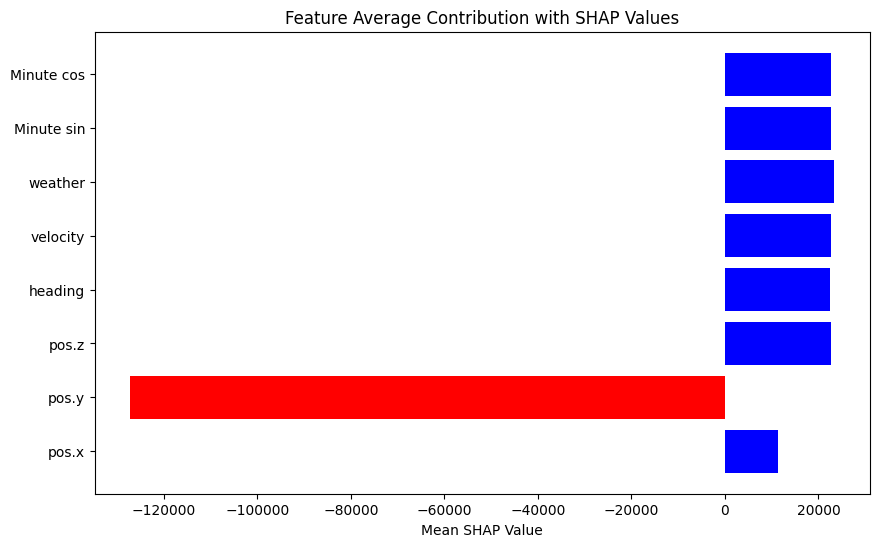

In [35]:
shap_exp.plot_shap_values(shap_values)

### LIME

In [42]:
lime_exp = LIME()

In [43]:
# Fit the explainer
lime_exp.fit_exp(
    model=blackbox.predict,
    loss=(lambda pred, true: blackbox.loss(true, pred)),
    features_list_names=["pos.x", "pos.y", "pos.z", "heading", "velocity", "weather", "Minute sin", "Minute cos"],
    labels_name=['pos.x', 'pos.y']
)

In [44]:
best_samples, best_samples_pred, distance_scores, mse_scores = lime_exp.blackbox_evaluation(y=y)

1/1 [==============================] - 0s 17ms/step


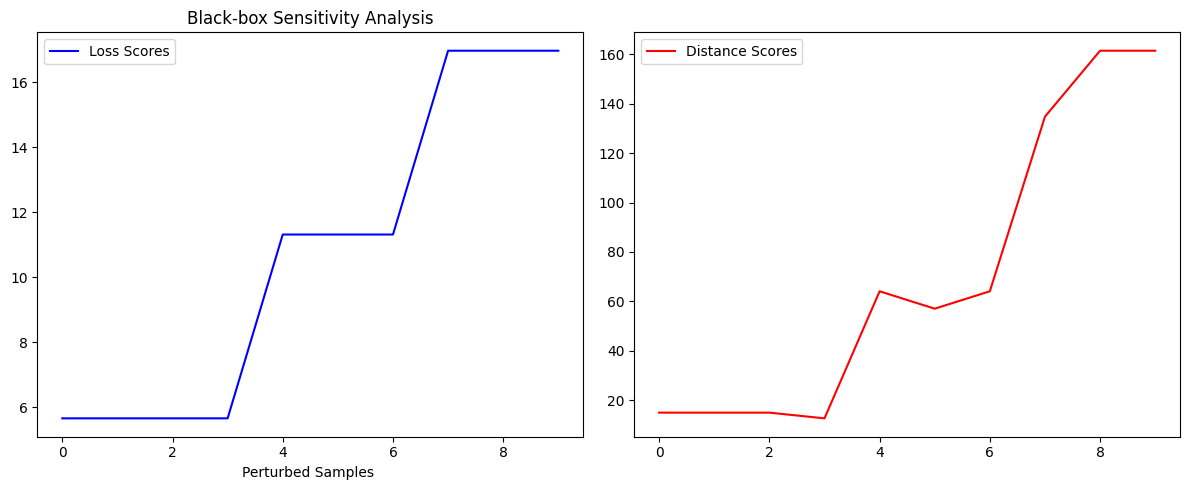

In [45]:
lime_exp.plot_blackbox_evaluation(distance_scores, mse_scores)

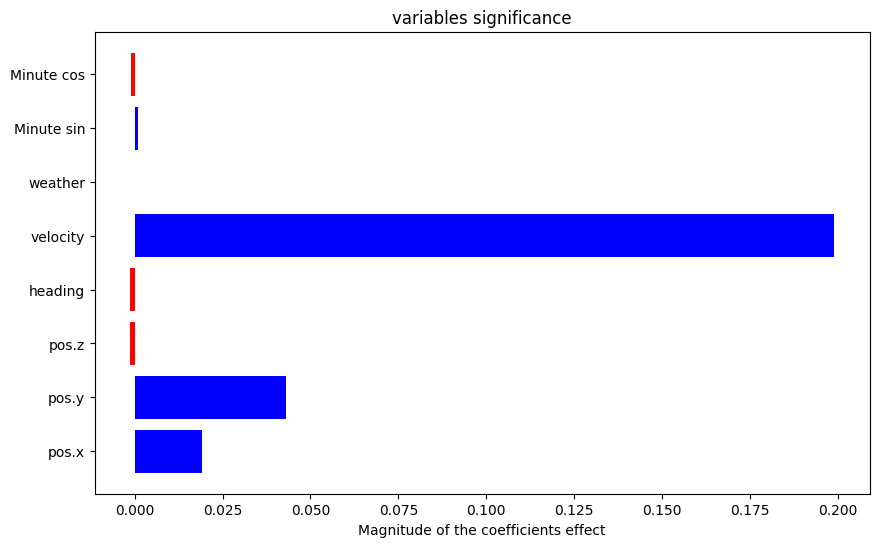

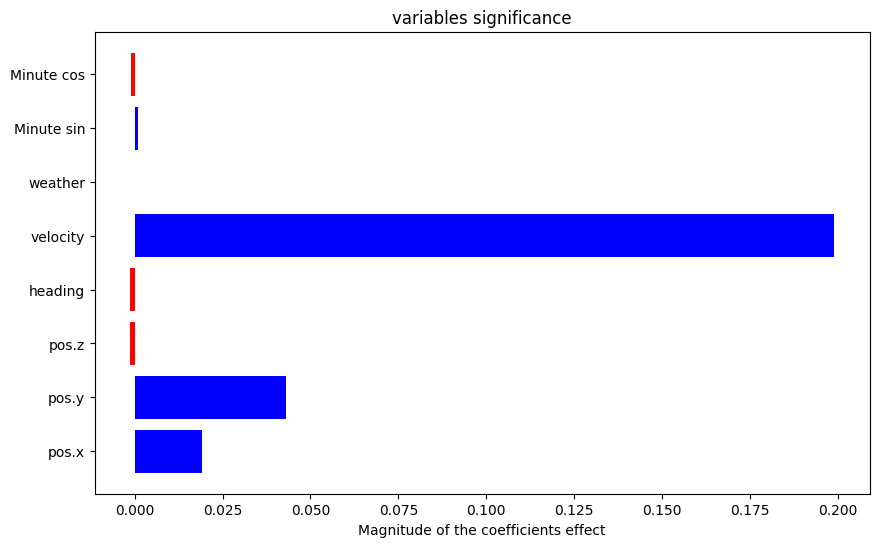

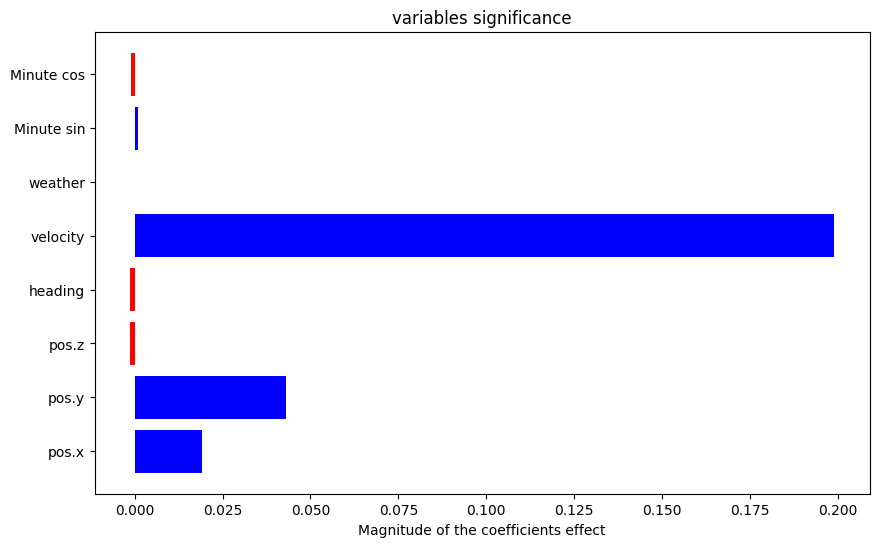

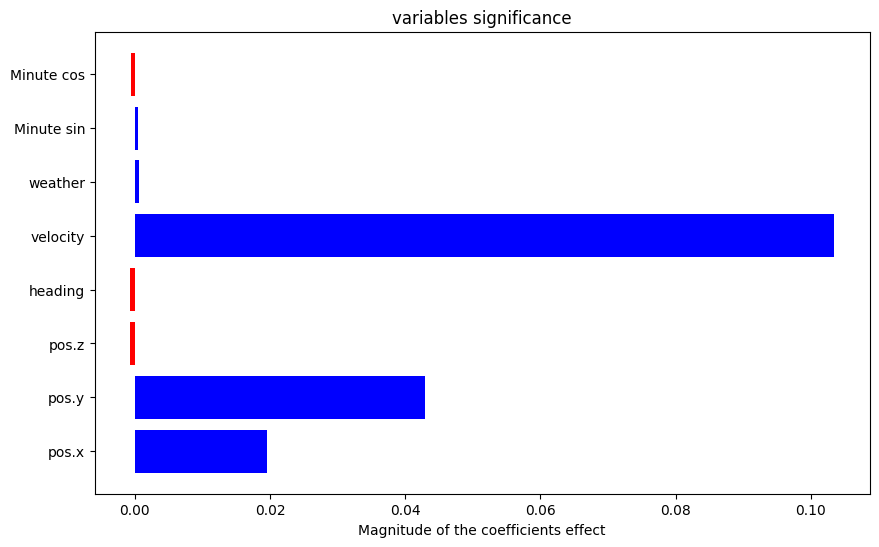

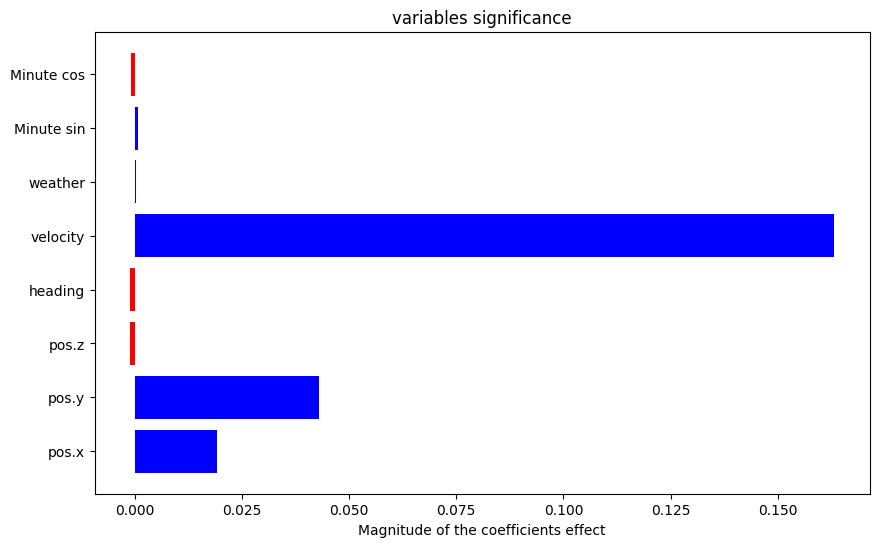

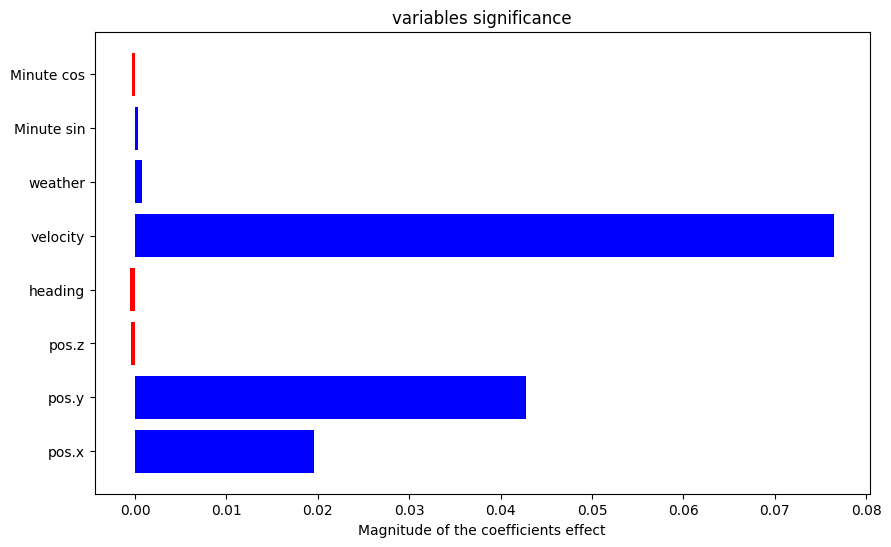

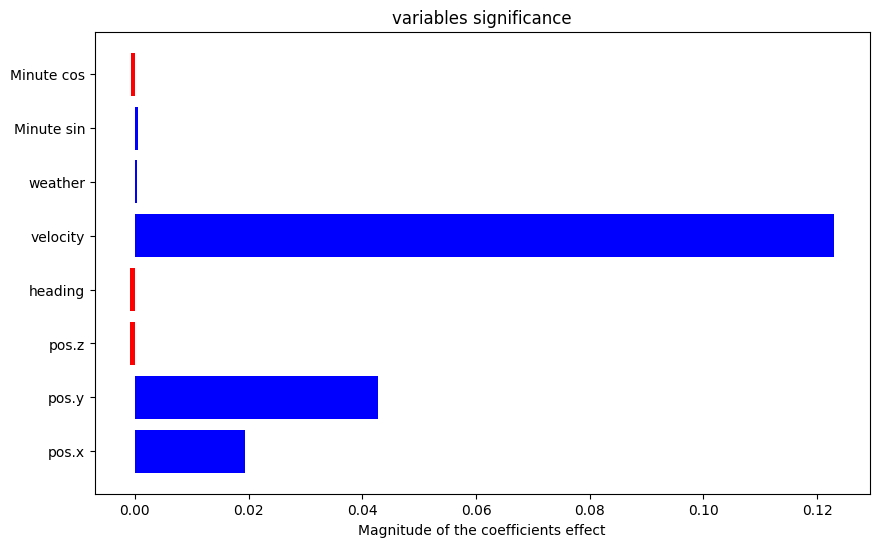

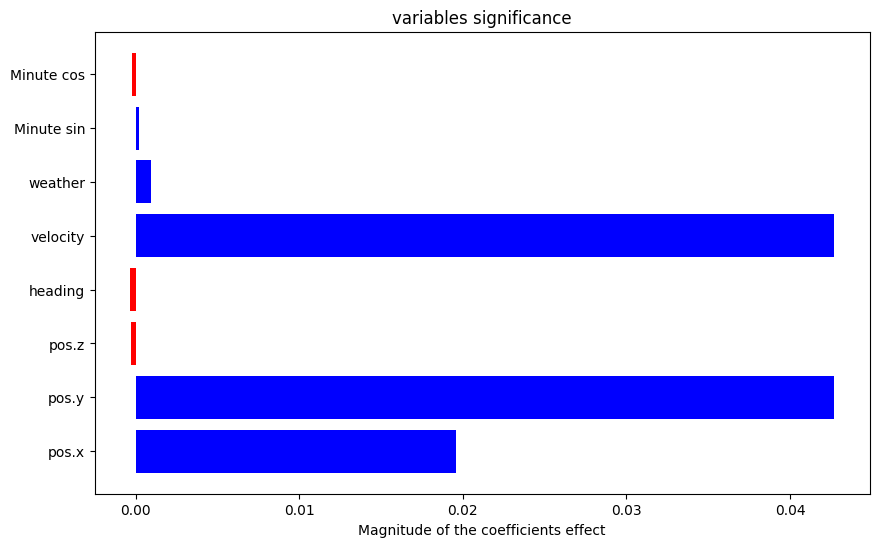

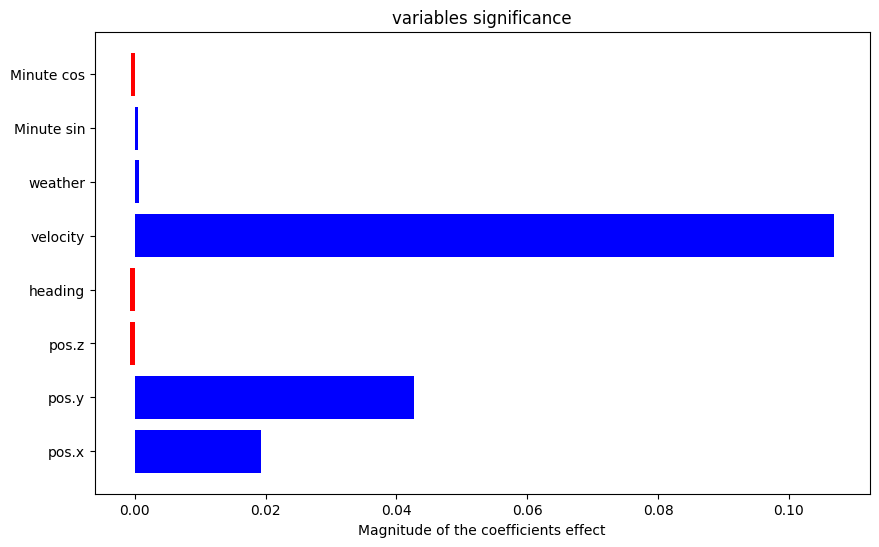

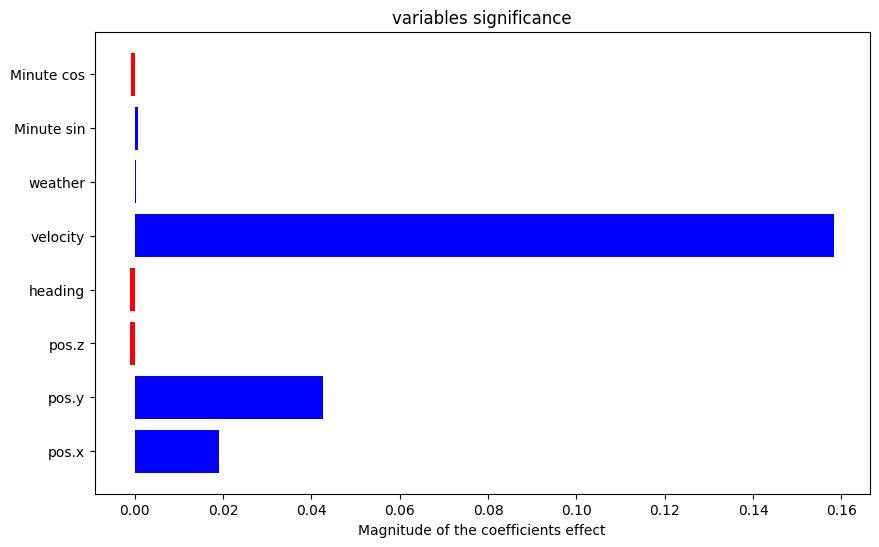

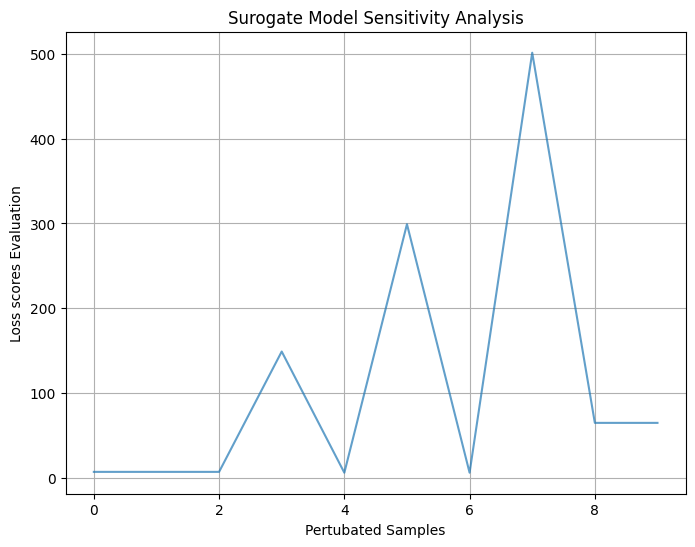

In [46]:
lime_exp.average_feature_effect(best_samples, best_samples_pred)